# 概要

Character-LevelのCNNでWAFを作る。  
論文の内容をKerasで実装してみる。  
原著論文はこちら http://iyatomi-lab.info/sites/default/files/user/CSPA2018%20Proceedings_ito.pdf 


## データの準備

In [44]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

import tensorflow as tf
import keras
from keras.models import Sequential, Model
from keras.layers import Input, Embedding
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv1D, MaxPool1D
from keras.layers import Add, Reshape, normalization, Concatenate
from keras.utils import plot_model
from keras import backend as K

In [6]:
%cd /content/drive/MyDrive/WAffle/
!ls -al

/content/drive/MyDrive/WAffle
total 41
-rw------- 1 root root   151 Dec 18 14:37 2020-12-18.gslides
-rw------- 1 root root 28393 Dec 31 04:36 CharacterLevel-CNN
drwx------ 2 root root  4096 Dec 27 18:45 Dataset
drwx------ 2 root root  4096 Dec 27 13:42 KerasPractice
drwx------ 2 root root  4096 Dec 30 12:35 model_dir
-rw------- 1 root root   151 Oct 26 12:09 WAF_Overview_補足資料.gslides


In [7]:
df = pd.read_csv('Dataset/cisc_database/csic_database.csv')

In [8]:
df = df.rename(columns={'Unnamed: 0':'Target'})

In [9]:
# Targetカラムの変更。
# if (df['Target'] == Normal){0} else {1}

df['Target'] = df['Target'].apply(lambda x:0 if str(x) == 'Normal' else 1)
df.head()

,Target,Method,User-Agent,Pragma,Cache-Control,Accept,Accept-encoding,Accept-charset,language,host,cookie,content-type,connection,lenght,content,classification,URL
0,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=1F767F17239C9B670A39E9B10C3825F4,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/index.jsp HTTP/1.1
1,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=81761ACA043B0E6014CA42A4BCD06AB5,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/anadir.j...
2,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=933185092E0B668B90676E0A2B0767AF,application/x-www-form-urlencoded,Connection: close,Content-Length: 68,id=3&nombre=Vino+Rioja&precio=100&cantidad=55&...,0,http://localhost:8080/tienda1/publico/anadir.j...
3,0,GET,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=8FA18BA82C5336D03D3A8AFA3E68CBB0,NaN,close,NaN,NaN,0,http://localhost:8080/tienda1/publico/autentic...
4,0,POST,Mozilla/5.0 (compatible; Konqueror/3.5; Linux)...,no-cache,no-cache,"text/xml,application/xml,application/xhtml+xml...","x-gzip, x-deflate, gzip, deflate","utf-8, utf-8;q=0.5, *;q=0.5",en,localhost:8080,JSESSIONID=7104E6C68A6BCF1423DAE990CE49FEE2,application/x-www-form-urlencoded,Connection: close,Content-Length: 63,modo=entrar&login=choong&pwd=d1se3ci%F3n&remem...,0,http://localhost:8080/tienda1/publico/autentic...


In [10]:
X, y = train_test_split(df, train_size=0.8, test_size=0.2, random_state=42)

In [11]:
X_train, X_test = train_test_split(X, train_size=0.8, test_size=0.2, random_state=42)
y_train, y_test = train_test_split(y, train_size=0.8, test_size=0.2, random_state=42)

In [12]:
print('x_train shape', X_train.shape)
print('y_train shape', y_train.shape)
print('x_test shape', X_test.shape)
print('y_test shape', y_test.shape)

x_train shape (39081, 17)
y_train shape (9770, 17)
x_test shape (9771, 17)
y_test shape (2443, 17)


## アーキテクチャ

1. Input(1000 characters)
2. Embedding(128demensions)
3. Conv(kernelsize = K, filter_num = 64) -> RELU
4. Max Pooling(kernelsize = K)
5. Conv(kernelsize = K, filter_num = 64) -> RELU
6. Max Pooling(kernel_size = size of Conv 5's output)
7. concat output & reshape into 256 length vector
8. FCN(64 units) -> RELU
9. Batch normalize
10. Dropout(0.5)
11. FCN(1 unit) -> Sigmoid

(categorical_crossentropy)

In [13]:
#いつか使う URL decode
import urllib.parse
def url_decode(encoded_URL):
  return urllib.parse.unquote(encoded_URL)

In [14]:
# 文字列の特徴ベクトル変換
alphabet = "abcdefghijklmnopqrstuvwxyz0123456789,;.!?:'\"/\\|_@#$%^&*~`+-=<>()[]{}"
char_dict = {}
for i, char in enumerate(alphabet):
    char_dict[char] = i + 1
string_size = len(alphabet)

In [15]:
# config
input_max_size = 1000
embedding_size = 128
conv_layers = 4
kernel_sizes = [4,5,6,7]
filter_num = 64
fully_connected_layers = [64,64]
num_of_classes = 2
dropout = 0.5
optimizer = 'adam'
loss = 'categorical_crossentropy'

In [35]:
def create_model(input_max_size, embedding_size, conv_layers, kernel_sizes, filter_num, fully_connected_layers):
  # Input Layer
  # URLdecodeされた文字列をInputとして与える。
  inputs = Input(shape=(input_max_size,), name='decoded_URL_input', dtype='int64')

  # Embedding Layer
  x = Embedding(string_size +1, embedding_size, input_length=input_max_size)(inputs)
  x = Reshape((input_max_size, embedding_size, 1))(x)

  # Convolution Layers
  convolution_output = []
  for conv_layer in range(conv_layers):
    y = Conv1D(filter_num, kernel_sizes[conv_layer], activation='relu')(x)
    #y = Flatten()(y)
    #y = Reshape((1000, 8000))(y)
    y = MaxPooling1D(pool_size=kernel_sizes[conv_layer])(y)
    
    y = Conv1D(filter_num, kernel_sizes[conv_layer], activation='relu')(y)
    #y = Reshape((1000, 8000))(y)
    #y = Flatten()(y)
    y = MaxPooling1D(pool_size=y)(y)
    convolution_output.append(y)

  # concat output
  x = concatenate(convolution_output)

  # reshape into 256 length vector
  x = Reshape(256)(x)

  # Fully Connected Layers
  # x = Flatten()(x)
  x = Dense(64, activation='relu')(x)

  # Batch Normalization
  x = normalization.BatchNormalization()(x)
  
  # DropOut
  x = Dropout(dropout)(x)

  # Fully Connected Layers
  predictions = Dense(1, activation='softmax')(x)

  model = Model(input=inputs, outputs=predictions)
  plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)
  return model

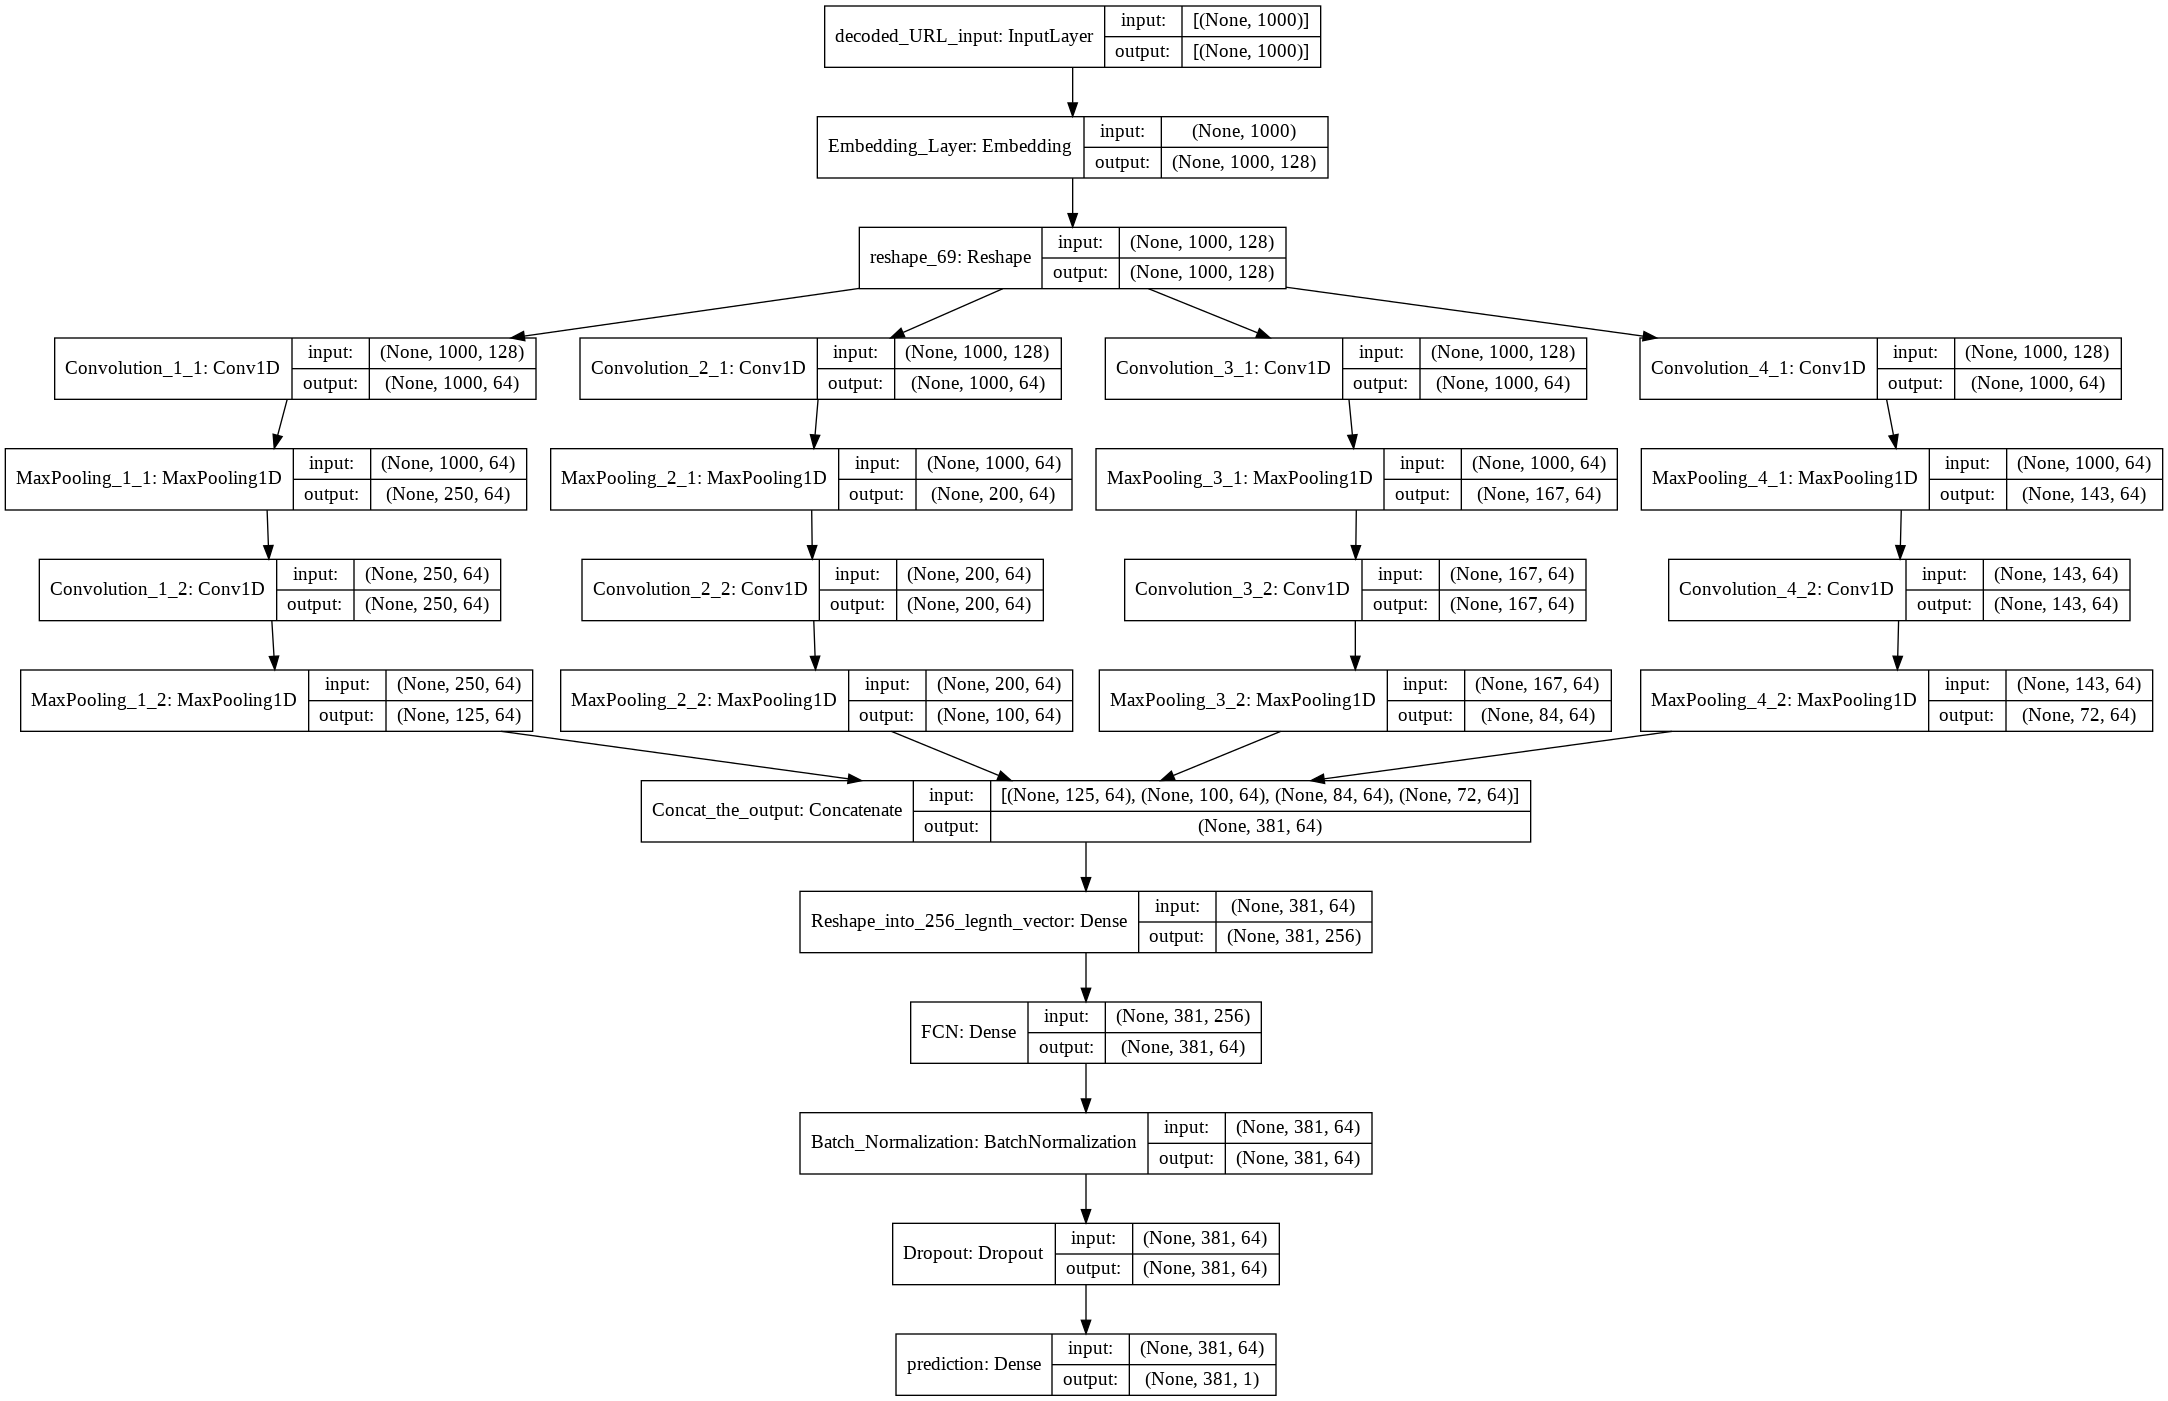

In [80]:
# Input Layer
# URLdecodeされた文字列をInputとして与える。
inputs = Input(shape=(input_max_size,), name='decoded_URL_input', dtype='int64')

# Embedding Layer
x = Embedding(string_size +1, embedding_size, input_length=input_max_size, name='Embedding_Layer')(inputs)
x = Reshape((input_max_size, embedding_size))(x)

# Convolution Layers
convolution_output = []

conv1_1 = Conv1D(filter_num, 4, activation='relu', padding='same', name='Convolution_1_1')(x)
pool1_1 = MaxPool1D(pool_size=4, padding='same', name='MaxPooling_1_1')(conv1_1)
conv1_2 = Conv1D(filter_num,4, activation='relu', padding='same', name='Convolution_1_2')(pool1_1)
pool1_2 = MaxPool1D(padding='same', name='MaxPooling_1_2')(conv1_2)
convolution_output.append(pool1_2)

conv2_1 = Conv1D(filter_num,5, activation='relu', padding='same', name='Convolution_2_1')(x)
pool2_1 = MaxPool1D(pool_size=5, padding='same', name='MaxPooling_2_1')(conv2_1)
conv2_2 = Conv1D(filter_num,5, activation='relu', padding='same', name='Convolution_2_2')(pool2_1)
pool2_2 = MaxPool1D(padding='same', name='MaxPooling_2_2')(conv2_2)
convolution_output.append(pool2_2)

conv3_1 = Conv1D(filter_num, 6, activation='relu', padding='same', name='Convolution_3_1')(x)
pool3_1 = MaxPool1D(pool_size=6, padding='same', name='MaxPooling_3_1')(conv3_1)
conv3_2 = Conv1D(filter_num, 6, activation='relu', padding='same', name='Convolution_3_2')(pool3_1)
pool3_2 = MaxPool1D(padding='same', name='MaxPooling_3_2')(conv3_2)
convolution_output.append(pool3_2)

conv4_1 = Conv1D(filter_num,7, activation='relu', padding='same', name='Convolution_4_1')(x)
pool4_1 = MaxPool1D(pool_size=7, padding='same', name='MaxPooling_4_1')(conv4_1)
conv4_2 = Conv1D(filter_num, 7, activation='relu', padding='same', name='Convolution_4_2')(pool4_1)
pool4_2 = MaxPool1D(padding='same', name='MaxPooling_4_2')(conv4_2)
convolution_output.append(pool4_2)

# concat output
x = Concatenate(axis=-2, name='Concat_the_output')(convolution_output)

# reshape into 256 length vector
x = Dense(256, name='Reshape_into_256_legnth_vector')(x)

# Fully Connected Layers
# x = Flatten()(x)
x = Dense(64, activation='relu', name='FCN')(x)

# Batch Normalization
x = normalization.BatchNormalization(name='Batch_Normalization')(x)

# DropOut
x = Dropout(dropout, name='Dropout')(x)

# Fully Connected Layers
predictions = Dense(1, activation='softmax', name='prediction')(x)

model = Model(inputs=inputs, outputs=predictions)
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [84]:
#Model = create_model(input_max_size, embedding_size, conv_layers, kernel_sizes, filter_num, fully_connected_layers)
#model.conpile(loss=loss, optimizer=optimizer, metrics=['accuracy'])
model.summary()

Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
decoded_URL_input (InputLayer)  [(None, 1000)]       0                                            
__________________________________________________________________________________________________
Embedding_Layer (Embedding)     (None, 1000, 128)    8832        decoded_URL_input[0][0]          
__________________________________________________________________________________________________
reshape_69 (Reshape)            (None, 1000, 128)    0           Embedding_Layer[0][0]            
__________________________________________________________________________________________________
Convolution_1_1 (Conv1D)        (None, 1000, 64)     32832       reshape_69[0][0]                 
____________________________________________________________________________________________

In [ ]:
def load_data(Dataframe, )

In [ ]:
def train(inputs, targets, batch_size=100, epochs=20, max_length=1000, model_filepath="./model_dir/", learning_rate=0.001):
  start = learning_rate
  stop = learning_rate * 0.01
  learning_rates = np.linspace(start, stop. epochs)

  model =create_model()